In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone 'https://github.com/tcapelle/Diffusion-Models-pytorch.git'

Cloning into 'Diffusion-Models-pytorch'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 182 (delta 99), reused 164 (delta 96), pack-reused 4
Receiving objects: 100% (182/182), 5.58 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
cd '/content/Diffusion-Models-pytorch'

/content/Diffusion-Models-pytorch


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext

import torch
from torch import optim
import torch.nn as nn
import numpy as np
from fastprogress import progress_bar
import matplotlib.pyplot as plt


import time
import torch.nn.functional as F
import wandb

In [ ]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

In [ ]:
def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)


        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 512)
            self.bot2 = DoubleConv(512, 512)
            self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=one_param(self).device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)


class UNet_conditional(UNet):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        return self.unet_forwad(x, t)

In [ ]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, num_classes=10, c_in=3, c_out=3, device="cuda", **kwargs):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = UNet_conditional(c_in, c_out, num_classes=num_classes, **kwargs).to(device)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in
        self.num_classes = num_classes

    def alpha_beta(self):
        return (self.alpha, self.beta, self.alpha_hat)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    @torch.inference_mode()
    def sample(self, model, labels, cfg_scale=3):
        #model = self.ema_model if use_ema else self.model
        n = len(labels)
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.inference_mode():
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def one_epoch(self, train=True):
        avg_loss = 0.
        if train: self.model.train()
        else: self.model.eval()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for i, (images, labels) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                images = images.to(self.device)
                labels = labels.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)
                if np.random.random() < 0.1:
                    labels = None
                predicted_noise = self.model(x_t, t, labels)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
                wandb.log({"train_mse": loss.item(),
                            "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"MSE={loss.item():2.3f}"
        return avg_loss.mean().item()

    def log_images(self):
        "Log images to wandb and save them to disk"
        labels = torch.arange(self.num_classes).long().to(self.device)
        sampled_images = self.sample(use_ema=False, labels=labels)
        wandb.log({"sampled_images":     [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in sampled_images]})

        # EMA model sampling
        ema_sampled_images = self.sample(use_ema=True, labels=labels)
        plot_images(sampled_images)  #to display on jupyter if available
        wandb.log({"ema_sampled_images": [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in ema_sampled_images]})

    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))

    def save_model(self, run_name, epoch=-1):
        "Save model locally and on wandb"
        torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))
        at = wandb.Artifact("model", type="model", description="Model weights for DDPM conditional", metadata={"epoch": epoch})
        at.add_dir(os.path.join("models", run_name))
        wandb.log_artifact(at)

    def prepare(self, args):
        mk_folders(args.run_name)
        self.train_dataloader, self.val_dataloader = get_data(args)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr,
                                                 steps_per_epoch=len(self.train_dataloader), epochs=args.epochs)
        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()

    def fit(self, args):
        for epoch in progress_bar(range(args.epochs), total=args.epochs, leave=True):
            logging.info(f"Starting epoch {epoch}:")
            _  = self.one_epoch(train=True)

            ## validation
            if args.do_validation:
                avg_loss = self.one_epoch(train=False)
                wandb.log({"val_mse": avg_loss})

            # log predicitons
            if epoch % args.log_every_epoch == 0:
                self.log_images()

        # save model
        self.save_model(run_name=args.run_name, epoch=epoch)

Time elapsed:  268.83460783958435


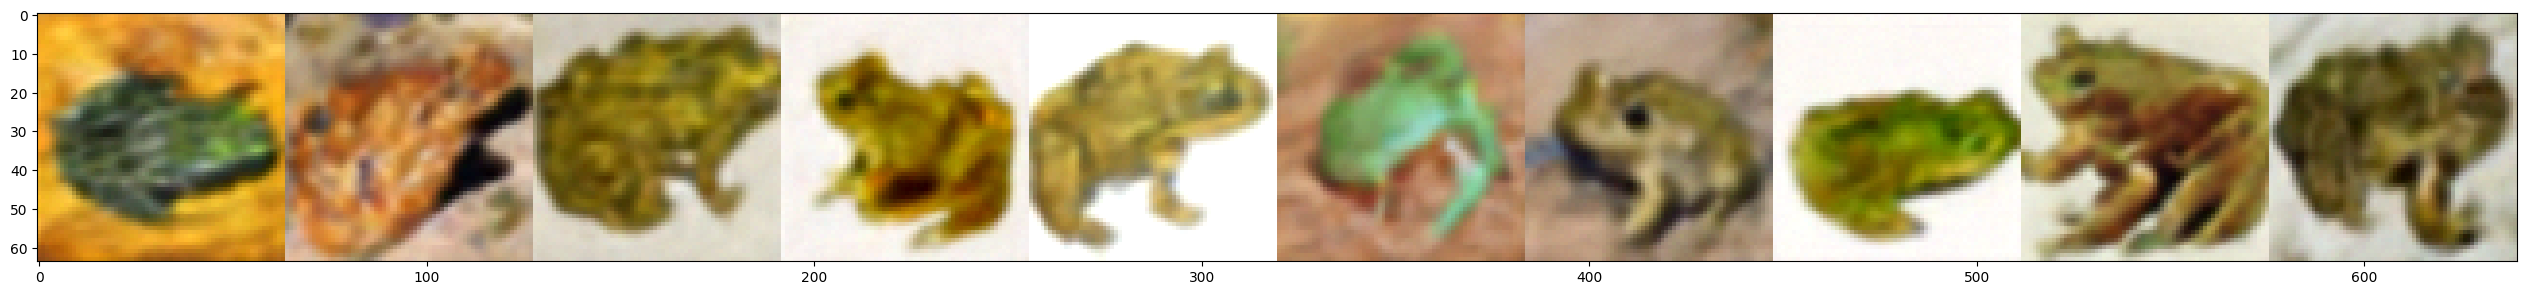

In [ ]:
n = 10
device = "cuda"

start_time = time.time()

model = UNet_conditional(num_classes=10).to(device)
model = model.eval().requires_grad_(False)
ckpt = torch.load("conditional_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
y = torch.Tensor([6] * n).long().to(device)
#x = diffusion.sample(model, n, y)
x = diffusion.sample(model, y, cfg_scale=3)

end_time = time.time()

print("Time elapsed: ", end_time-start_time)
plot_images(x)